In [1]:
#import modules
import numpy as np
import pandas as pd
import time
from keras import backend as K 
from keras.engine.training import Model
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
train_cols = ["Outflow"]
label_cols = ["Outflow(t+1)"]

In [4]:
new_df = df.filter(train_cols, axis=1)

In [5]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [6]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

#getting data ready for training the model
def data_processing(lag_df):
    #Splitting training and test data
    df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
    x_train = df_train.loc[:,train_cols].values
    y_train = df_train.loc[:,label_cols].values
    x_test = df_test.loc[:,train_cols].values
    y_test = df_test.loc[:,label_cols].values    
   
    #Normalizing training data
    x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
    y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

    # Normalizing test data
    x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    y_test_nor = ytest_min_max_scaler.fit_transform(y_test)
    
    # Saving actual train and test y_label
    y_train_actual = y_train
    y_test_actual = y_test
    
    #Building timeseries
    X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
    X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)
    
    return X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual

In [7]:
#calling function to create lag dataframe
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)
X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual = data_processing(lag_df)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



length of time-series i/o (148416, 18, 1) (148416,)



length of time-series i/o (37091, 18, 1) (37091,)


In [8]:
#Build Model
def make_model(X_Train):
    input_layer = Input(shape=(X_Train.shape[1], X_Train.shape[2]))

    lstm1 = LSTM(units=16, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.2)(lstm1)
    lstm2 = LSTM(units=32, return_sequences=True)(dropout1)
    dropout2 = Dropout(0.2)(lstm2)
    lstm3 = LSTM(units=64, return_sequences=True)(dropout2)
    dropout3 = Dropout(0.2)(lstm3)
    lstm4 = LSTM(units=128)(dropout3)
    dropout4 = Dropout(0.2)(lstm4)

    dense1 = Dense(128, activation='relu')(dropout4)
    dense2 = Dense(64, activation='relu')(dense1)
    dense3 = Dense(32, activation='relu')(dense2)
    dense4 = Dense(16, activation='relu')(dense3)
    output_layer = Dense(1, activation='linear')(dense4)
    
    return Model(inputs=input_layer, outputs=output_layer)



In [9]:
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []
def run_iteration(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model = make_model(X_Train)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Train, Y_Train, epochs=epochs,
                       validation_data=(X_Test, Y_Test))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
    end_time = time.time()
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values_unnor, model

predicted_y_values_unnor, model = run_iteration(20,10)

Iteration: 1
Epoch 1/10
4638/4638 [==============================] - 231s 50ms/step - loss: 1.8438e-04 - val_loss: 8.6733e-05
Epoch 2/10
4638/4638 [==============================] - 226s 49ms/step - loss: 8.0252e-05 - val_loss: 4.8742e-05
Epoch 3/10
4638/4638 [==============================] - 238s 51ms/step - loss: 5.7771e-05 - val_loss: 2.5473e-05
Epoch 4/10
4638/4638 [==============================] - 246s 53ms/step - loss: 4.5408e-05 - val_loss: 1.4558e-04
Epoch 5/10
4638/4638 [==============================] - 220s 47ms/step - loss: 4.0961e-05 - val_loss: 1.1644e-04
Epoch 6/10
4638/4638 [==============================] - 213s 46ms/step - loss: 3.4783e-05 - val_loss: 1.2408e-05
Epoch 7/10
4638/4638 [==============================] - 231s 50ms/step - loss: 2.6075e-05 - val_loss: 1.7920e-05
Epoch 8/10
4638/4638 [==============================] - 214s 46ms/step - loss: 2.8713e-05 - val_loss: 1.1728e-05
Epoch 9/10
4638/4638 [==============================] - 211s 46ms/step - loss: 2.38

4638/4638 [==============================] - 114s 24ms/step - loss: 6.7189e-05 - val_loss: 7.0398e-05
Epoch 3/10
4638/4638 [==============================] - 114s 24ms/step - loss: 4.9730e-05 - val_loss: 1.4978e-05
Epoch 4/10
4638/4638 [==============================] - 113s 24ms/step - loss: 3.7525e-05 - val_loss: 1.3912e-04
Epoch 5/10
4638/4638 [==============================] - 120s 26ms/step - loss: 3.7510e-05 - val_loss: 5.0353e-05
Epoch 6/10
4638/4638 [==============================] - 125s 27ms/step - loss: 3.2862e-05 - val_loss: 1.3833e-05
Epoch 7/10
4638/4638 [==============================] - 125s 27ms/step - loss: 2.8650e-05 - val_loss: 3.8155e-05
Epoch 8/10
4638/4638 [==============================] - 125s 27ms/step - loss: 2.5790e-05 - val_loss: 1.4618e-05
Epoch 9/10
4638/4638 [==============================] - 125s 27ms/step - loss: 2.4120e-05 - val_loss: 1.6800e-05
Epoch 10/10
4638/4638 [==============================] - 125s 27ms/step - loss: 2.2675e-05 - val_loss: 9.17

4638/4638 [==============================] - 120s 26ms/step - loss: 5.1632e-05 - val_loss: 3.7928e-05
Epoch 4/10
4638/4638 [==============================] - 120s 26ms/step - loss: 3.9692e-05 - val_loss: 3.1945e-05
Epoch 5/10
4638/4638 [==============================] - 120s 26ms/step - loss: 3.7208e-05 - val_loss: 4.6010e-05
Epoch 6/10
4638/4638 [==============================] - 120s 26ms/step - loss: 3.0914e-05 - val_loss: 1.7785e-05
Epoch 7/10
4638/4638 [==============================] - 121s 26ms/step - loss: 2.8727e-05 - val_loss: 3.2586e-05
Epoch 8/10
4638/4638 [==============================] - 121s 26ms/step - loss: 2.3603e-05 - val_loss: 2.1463e-05
Epoch 9/10
4638/4638 [==============================] - 122s 26ms/step - loss: 2.5540e-05 - val_loss: 7.1517e-05
Epoch 10/10
4638/4638 [==============================] - 121s 26ms/step - loss: 2.4403e-05 - val_loss: 1.5783e-05
Iteration: 16
Epoch 1/10
4638/4638 [==============================] - 126s 27ms/step - loss: 1.5336e-04 - 

In [10]:
model.save("lstm_model1_single_feature.hdf5")

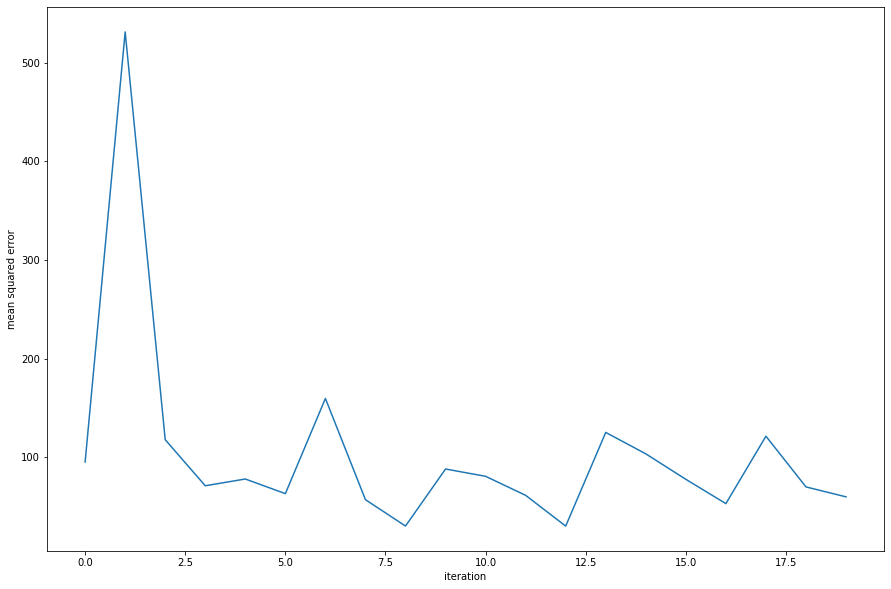

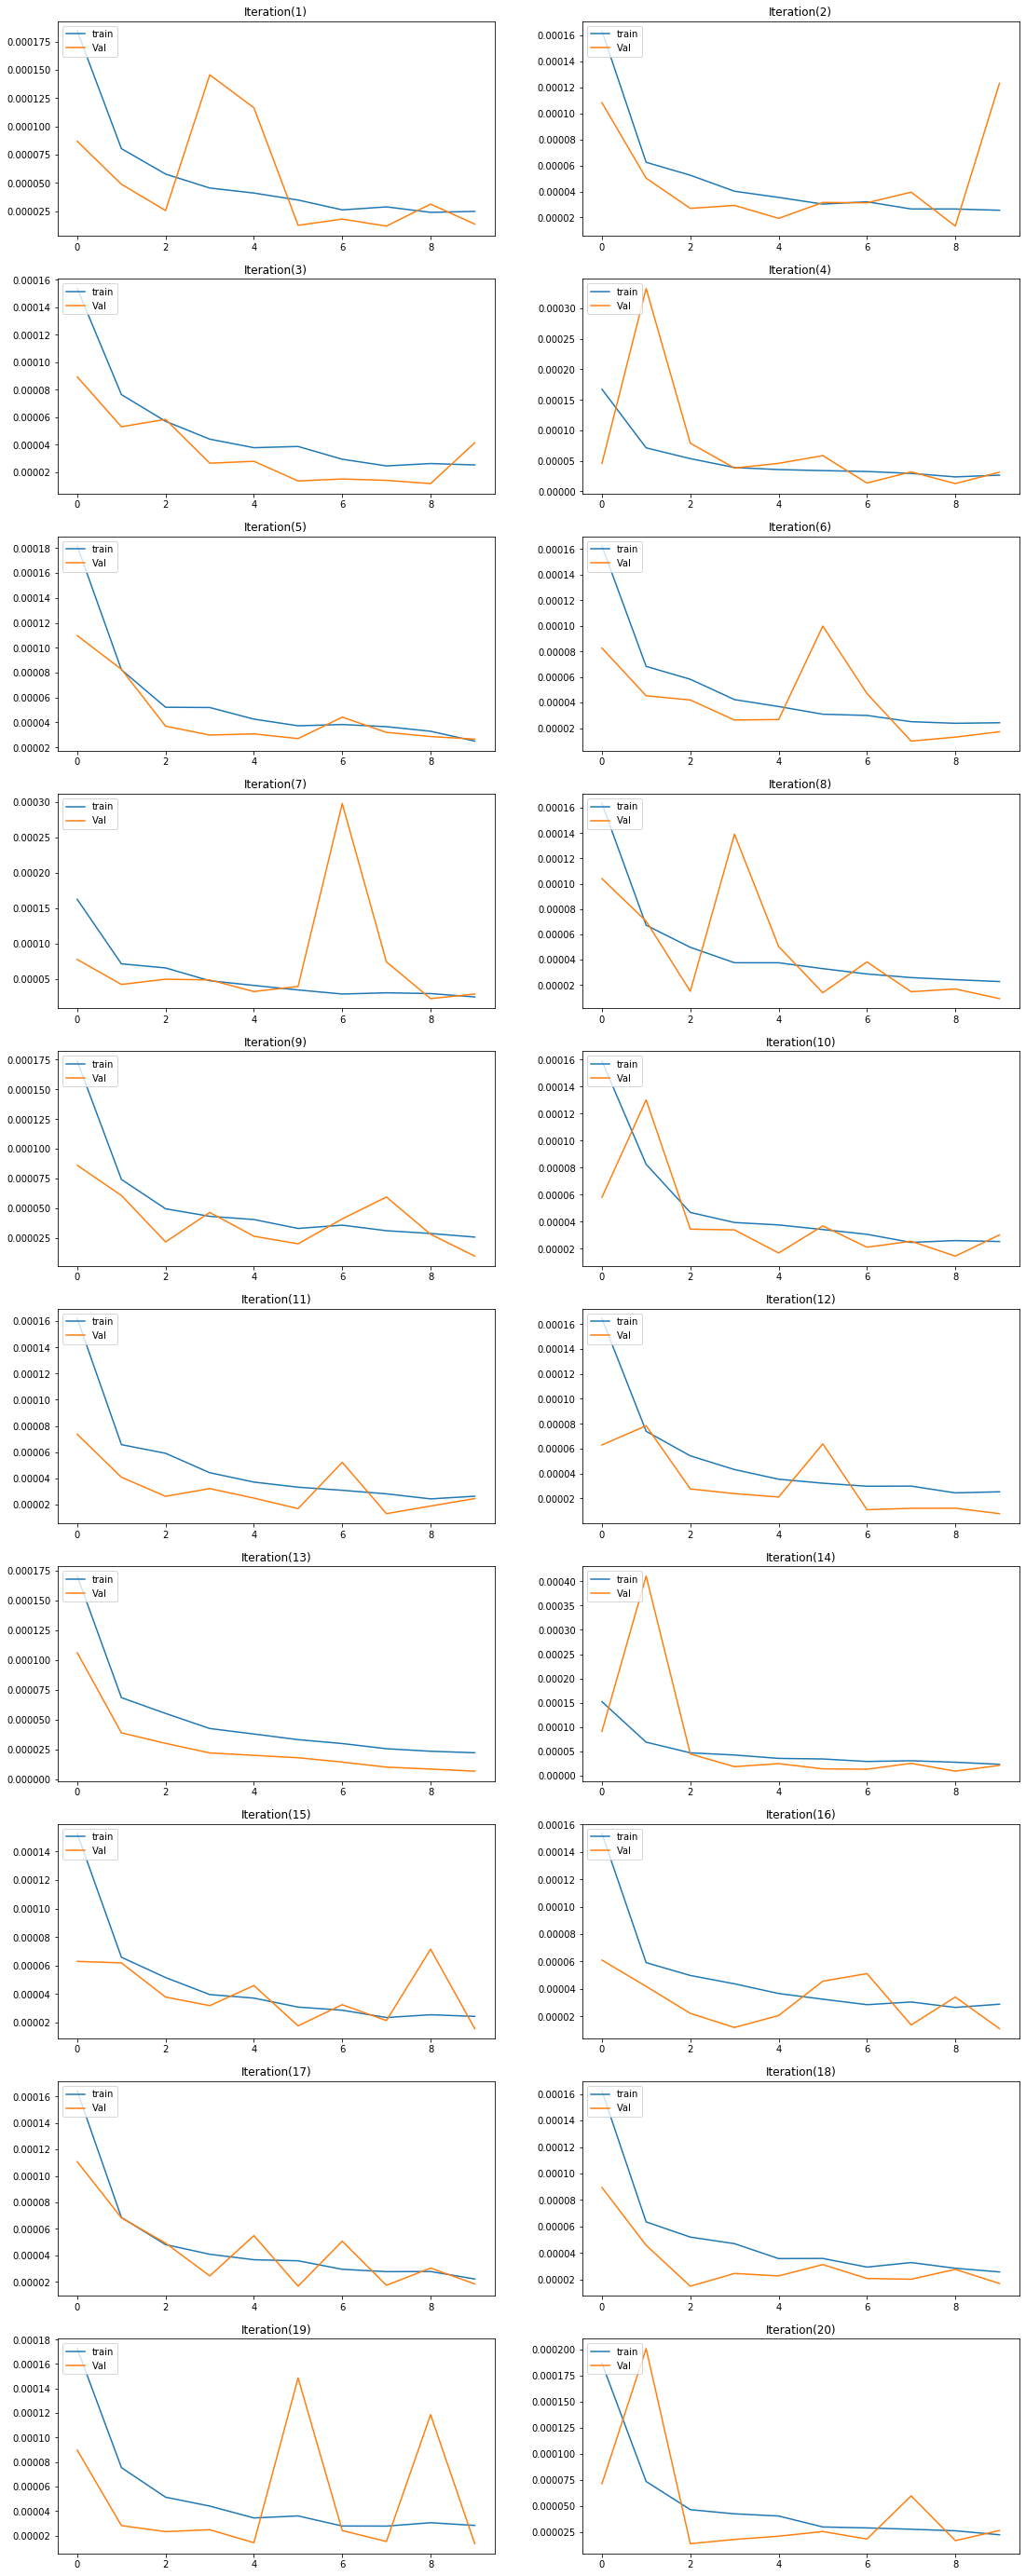

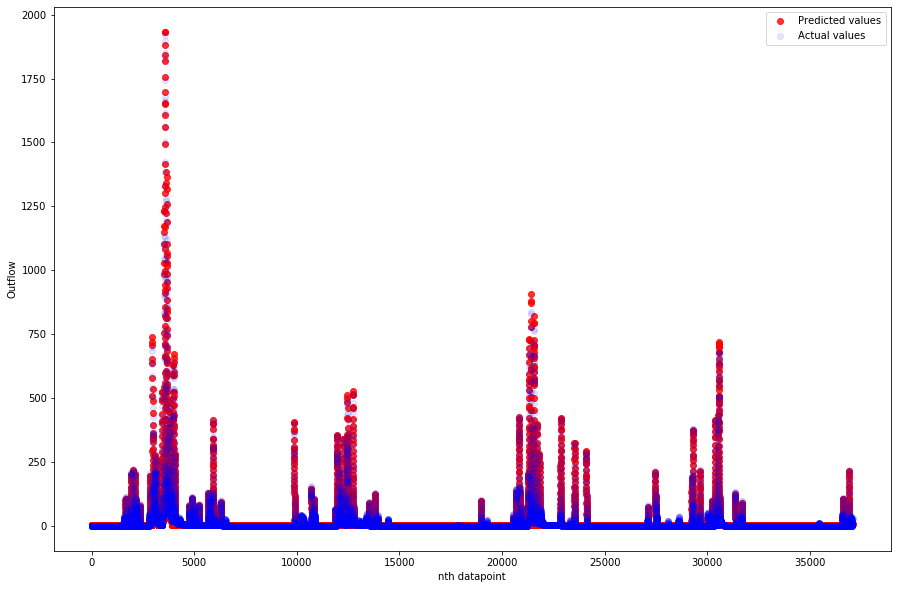

In [11]:
def plot_evaluation():
    #mean square error over iterations
    plt.figure(figsize=(15, 10))
    plt.plot(mse_for_iter)
    plt.ylabel('mean squared error')
    plt.xlabel('iteration')
    plt.savefig('mse1.png', bbox_inches='tight')
    plt.show()
        
    #plot train and validation loss over epochs for each iteration
    fig, axs = plt.subplots(10, 2)
    #axs.set_ylabel('loss')
    #axs.set_xlabel('epoch')
    fig.set_size_inches(18.5, 50)
    for row in range(10):
        for col in range(2):
            index = 2*row + col #index to get loss from training loss and validation loss list
            axs[row, col].plot(train_loss_over_epoch[index])
            axs[row, col].plot(val_loss_over_epoch[index])
            axs[row, col].set_title('Iteration(%d)' %(index+1))
            axs[row, col].legend(['train', 'Val'], loc='upper left')            
    plt.savefig('train_val_loss1.png', bbox_inches='tight')
    
    #plot predicted value vs actual values from last iteration
    plt.figure(figsize=(15, 10))
    plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
    plt.plot(Y_test_actual, 'bo', alpha=0.1)
    plt.legend(['Predicted values', 'Actual values'], loc='upper right')
    plt.ylabel('Outflow')
    plt.xlabel('nth datapoint')
    plt.savefig('predicted_values_visuals1.png', bbox_inches='tight')
    plt.show()
    
#call plot_evaluation function
plot_evaluation()

In [12]:
mse_for_iter

[95.24701957950332,
 531.1108985719645,
 117.85668324894479,
 71.19678236590835,
 78.03202918408815,
 63.20243614881448,
 159.67372184526036,
 57.07031640282269,
 30.378828910264687,
 88.17175532992431,
 80.76443351089665,
 61.47769387265367,
 30.322548940261818,
 125.23725150395725,
 103.54994388675802,
 77.72543352339306,
 53.08220098465251,
 121.42437929667842,
 70.02832842402005,
 59.961626571330775]

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 18, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 18, 32)            6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 18, 64)            24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 64)           

In [14]:
print(np.mean(mse_for_iter))

103.77571560510489


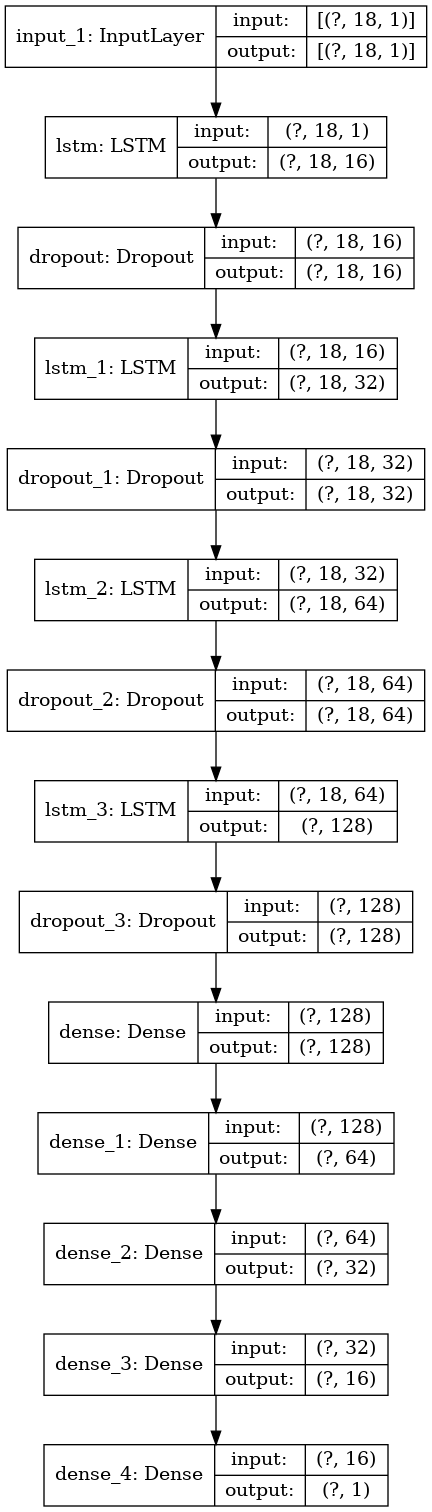

In [15]:
plot_model(model, show_shapes=True)